In [1]:
#Final Program

#Imports
import requests
import json
import math
import datetime
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytz import timezone
import time
import copy
from IPython.display import clear_output
import os

#Initial Parameters
optionChainLink = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"
header_para = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36'}
India_Time = timezone('Asia/Calcutta')  
timeOfData = []
strikePrices = []
filteredDict = defaultdict(dict)
Difference = defaultdict(list)
dataframe_list = []
graphData = defaultdict(list)
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
dataframe_list = [df1, df2, df3, df4]
totalDifference = defaultdict(list)
totalDifference_10 = defaultdict(list)
sumTotalPE = 0
sumTotalCE = 0
ten_min_trigger = 0
run = 0

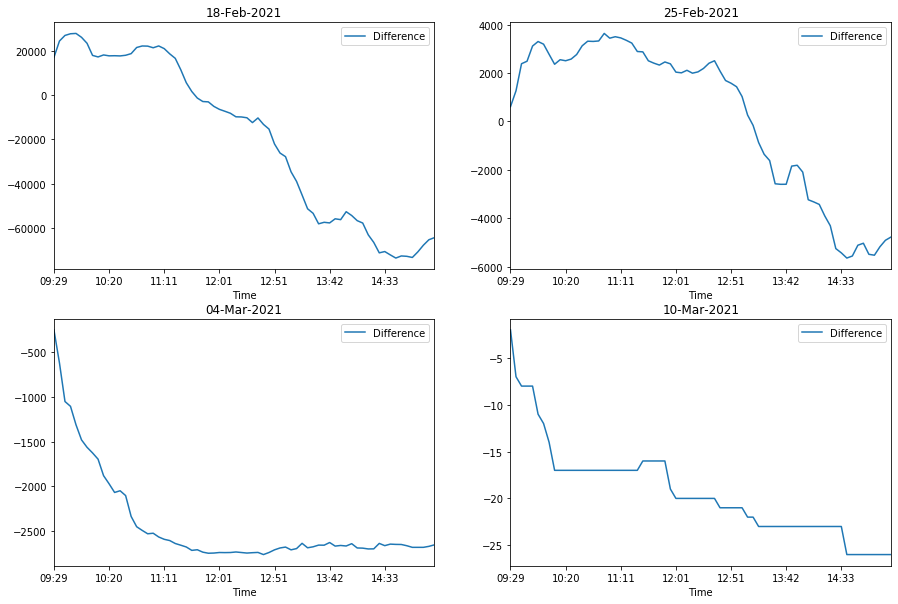

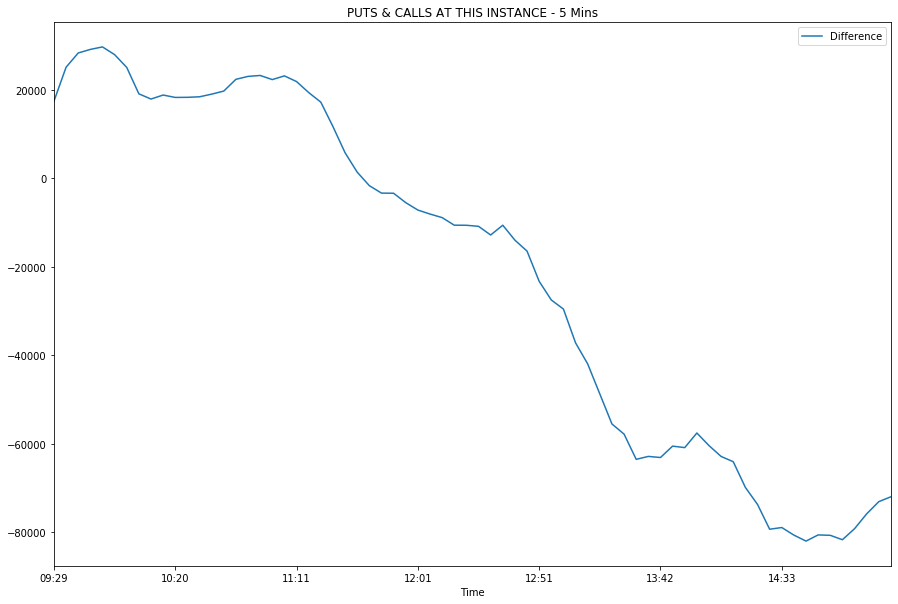

     Time  Difference
0   09:29       17466
1   09:35       25139
2   09:40       28356
3   09:45       29163
4   09:50       29730
..    ...         ...
65  14:57      -81648
66  15:02      -79153
67  15:07      -75797
68  15:12      -73041
69  15:18      -71938

[70 rows x 2 columns]


KeyError: 'records'

In [2]:
def showGraph():
    plt.show()
    
def saveData():
    os.mkdir(datetime.datetime.now().strftime('%d%b%y_100'))
    fig.savefig(datetime.datetime.now().strftime('%d%b%y_100') + "/Figures")

    master_fig = master.get_figure()
    master_fig.savefig(datetime.datetime.now().strftime('%d%b%y_100') + "/Master")

    writer = pd.ExcelWriter(datetime.datetime.now().strftime('%d%b%y_100') + "/Data.xlsx")
    for i in range(len(dataframe_list)):
        pd.DataFrame(dataframe_list[i], columns=['Time','Difference']).to_excel(writer, expiryDates[i])
    pd.DataFrame(totalDifference, columns=['Time', 'Difference']).to_excel(writer, 'Change In OI')
    writer.save()
    
#Interval of 5 minutes
while True:
    #Fetch Data from API to JSON
    data = None
    while data is None:
        try:
            with requests.session() as s:
                data = s.get(optionChainLink, headers = header_para).json()
                raw_data = json.dumps(data)
            option = json.loads(raw_data)
        except:
            pass

    #Current Nifty Price
    currentNifty = option['records']['underlyingValue']
    new = currentNifty/100

    #Getting expiry dates from dict
    expiryDates = option['records']['expiryDates'][:9]

    #Time of Data Received
    timeOfData.append(option['records']['timestamp'][-8:-3])

    #Date of the Data
    dateOfData = option['records']['timestamp'][:11]

    #Floor and Ceil Value for Strike Price Range
    if run == 0:
        ceilValue = (int(new)*100) + 100
        floorValue = (int(new)*100) - 100
        strikePrices = [strike for strike in option['records']['strikePrices'] if floorValue <= strike <= ceilValue]
        run = run + 1

    for block in option['records']['data'][:]:
        if block['strikePrice'] in strikePrices and block['expiryDate'] in expiryDates:
            date = block['expiryDate']
            sp = str(block['strikePrice'])
            try:
                pe = block['PE']['changeinOpenInterest']
                pe_oi = block['PE']['openInterest']
            except:
                pe = 0
                pe_oi = 0
            try:
                ce = block['CE']['changeinOpenInterest']
                ce_oi = block['CE']['openInterest']
            except:
                ce = 0
                ce_oi = 0
            filteredDict[date][sp] = {'PE': pe ,'CE': ce,'PE_OI': pe_oi ,'CE_OI': ce_oi}

    #Forming Graph for selected Date in Grid
    dataframeCounter = 0
    for selected_date in expiryDates[:4]:
        selectedDict = filteredDict[selected_date]
        datePE = [selectedDict[str(i)]['PE'] for i in strikePrices]
        dateCE = [selectedDict[str(i)]['CE'] for i in strikePrices]
        Difference[selected_date].append(sum(datePE) - sum(dateCE))
        graphData['Time'] = timeOfData
        graphData['Difference'] = Difference[selected_date]
        dataframe_list[dataframeCounter] = copy.deepcopy(graphData)
        dataframeCounter = dataframeCounter + 1

    #Formation of Pie Chart
    totalPE = [filteredDict[i][str(j)]['PE'] for i in expiryDates[:4] for j in strikePrices]
    totalCE = [filteredDict[i][str(j)]['CE'] for i in expiryDates[:4] for j in strikePrices]
    
    #Total Strike Price and Expiry Puts and Calls
    totalDifference['Difference'].append(sum(totalPE) - sum(totalCE))
    totalDifference['Time'] = timeOfData
    
    

    #Show Change in OI Graph
    fig, axes = plt.subplots(2, 2,figsize=(15,10))

    count = 0
    for r in [0,1]:
        for c in [0,1]:
            pd.DataFrame(dataframe_list[count]).plot(ax=axes[r,c], title = expiryDates[count],x = 'Time', y = 'Difference')
            count = count + 1
        
    master = pd.DataFrame(totalDifference, columns=['Time', 'Difference']).plot(title="PUTS & CALLS AT THIS INSTANCE - 5 Mins",x = 'Time', y='Difference', figsize=(15,10))
    
    if datetime.datetime.now(India_Time).strftime("%H:%M") > '15:30':
        showGraph()
        saveData()
        print('Market Closed')
        break
        
    clear_output(wait=True)
    
    #if ten_min_trigger == 1:
    #    totalDifference_10['Difference'].append(sum(totalPE) - sum(totalCE))
    #    totalDifference_10['Time'] = timeOfData
    #    master_10 = pd.DataFrame(totalDifference_10, columns=['Time', 'Difference']).plot(title="PUTS & CALLS AT THIS INSTANCE - 10 Mins",x = 'Time', y='Difference', figsize=(30,10))
    #    ten_min_trigger = 0
    #else:
    #    ten_min_trigger = ten_min_trigger + 1
        
    showGraph()  
    print(pd.DataFrame(totalDifference, columns=['Time', 'Difference']))
    
    time.sleep(300)

In [12]:
#Currently with Sensitivity of 150,other to be tested 300
#Two time frames to be build for 5 min and 10 min
#And run test on it to confirm bullish or bearish along with price action
#Try to create graph for volume as well to understand the change in hands of contract

In [ ]:
#Change from 150 to 100 range, add another field for nifty price, and nifty price graph embeded in it

In [3]:
saveData()